이름: 서영재

학번:20195178


## Final project 규칙

- 학생들 간의 질문은 금지합니다 (교수 및 조교에게 질문하세요)
- 대 원칙은 "내가 이해한 것만 활용하고 작성한다" 입니다
- 사용하는 기법들과 코드는 모두 보고서에 설명되어야하며, 설명이 없는 경우 감점이나 0점 처리합니다
    - 예를 들어서 검색한 끝에 model ensemble이라는 기법이 유용할 것 같아서, 참고하여 성능을 개선한 경우
        1. 참고자료의 출처를 작성할 것
        2. 기반 이론을 설명할 것
        3. 사용한 코드 분석 및 기법을 설명할 것
- 주석이 없는 경우 채점하지 않습니다
- Pretrained network은 사용하지 않습니다. 본 프로젝트에서는, random 초기화한 parameter들을 직접 학습하는 과정만 허용합니다
    - 랜덤 초기화 기법은 특별한 제약이 없습니다
- Competition 순위와 보고서는 각각 5:5로 점수가 반영됩니다.

# Final Project 

## Project: 새 품종 분류하기

## Due date: 2021.06.15

https://www.kaggle.com/c/detect-the-bird/leaderboard
---

* 아래 여러 셀에서 코드를 완성하는 부분을 수행하고, 보고서에 설명을 최대한 자세하게 적어주세요. 기준은 본인이 이해하고 있다는 것을 표현할 수 있는 부분을 모두 적으시면 됩니다.
  
  
> **제출방법**: 
* 보고서에는 코드 캡쳐 첨부이외에도, 각 코드를 작성하는 기반 이론, 방법론과 설명을 작성하세요.

### 목표: 앱을 위한 인공지능 알고리즘 개발 
* 본 보고서에서는 모바일/웹앱을 위한 인공지능 알고리즘을 개발하라는 업무를 부여받았다고 가정합니다
* 프로젝트가 완성본은, 사용자가 제공하는 image를 받아서 새의 종(種)을 예측합니다


---

## Step 0: Import library

- 필요하다 생각되는 라이브러리를 미리 import해 놓은 항목입니다.(참고)
- 필요 없는 라이브러리를 제거하거나 필요한 라이브러리를 추가하셔도 됩니다.

In [49]:
import shutil
import os
import glob
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

from pathlib import Path
from collections import OrderedDict

import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0 # 데이터로드에 사용할 하위 프로세스 수
batch_size = 64 #로드 할 배치 당 샘플 수

## Step 1: Dataset 준비하기

In [50]:
train_transform = transforms.Compose([                                                   # train_data에서 사용할 test transform을 구성합니다.
                                transforms.Resize((224,224)),                            # 이미지 사이즈를 224x224로 바꿉니다.
                                transforms.RandomHorizontalFlip(p=0.5),                  # 이미지를 랜덤으로 수평으로 뒤집습니다.
                                transforms.ToTensor(),                                   # 이미지를 텐서로 변형합니다.
                                transforms.Normalize((0.5 , 0.5, 0.5),(0.5 , 0.5, 0.5))  # 값을 MEANS : (0.5, 0.5, 0.5), DEVIATIOMS : (0.5, 0.5, 0.5) 값으로 정규화 시킵니다. 
                               ])

train_data = torchvision.datasets.ImageFolder(root='../input/detectthebird/imgs/train', transform = train_transform) # ImageFolder를 활용하여 train 데이터셋을 불러옵니다.

In [51]:
# 검증에 사용될 훈련 인덱스를 얻습니다.
# 검증으로 사용할 훈련 세트의 백분율

valid_size = 0.2 # trainning set 중 validation 데이터로 사용할 비율을 20퍼센트로 지정해줍니다.

# validation으로 사용할 trainning indices를 얻습니다.
num_train = len(train_data)      # train_data의 길이를 num_train에 저장해줍니다.
num_train = int(num_train)       # num_train을 int형으로 변환합니다.
indices = list(range(num_train)) # 0부터 num_train의 크기까지 들어있는 indices 리스트를 생성합니다.
np.random.shuffle(indices)       # indices 배열을 섞습니다.
split = int(np.floor(valid_size * num_train)) # (valid_size * num_train) 의 floor 값을 반환
train_idx, valid_idx = indices[split:], indices[:split] # split부터 마지막까지를 train_idx에, 상위부터 split까지를 valid_idx에 저장합니다.

# trainning, validation batch를 얻기 위한 sampler정의
train_sampler = SubsetRandomSampler(train_idx) # 훈련 배치를 얻기위한 train 샘플러 정의
valid_sampler = SubsetRandomSampler(valid_idx) # 검증 배치를 얻기위한 valid 샘플러 정의


## Step 2: Dataset 에 대한 Data Loaders 구성

In [53]:
# DataLoader를 사용하여 ImageFolder로 부터 받은 train_dataset을 받아서 image와 해당 label을 여러개의 batch 로 정리하여 return 합니다
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers) 
# DataLoader를 사용하여 valid_dataset을 받아서 image와 해당 label을 여러개의 batch 로 정리하여 return 합니다
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers) 

classes = [i.split('/')[-1] for i in sorted(glob.glob('../input/detectthebird/imgs/train/*'))] # 이미지 클래스를 지정합니다.

In [54]:
# n바로 이미지를 볼 수 있게 해주기 위해 사용합니다.

%matplotlib inline 
def imshow(img):  # 이미지를 비정규화하고 시각화하는 도우미 함수                          
    img = img / 2 + 0.5                       # 비정규화
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Tensor 이미지에서 변환

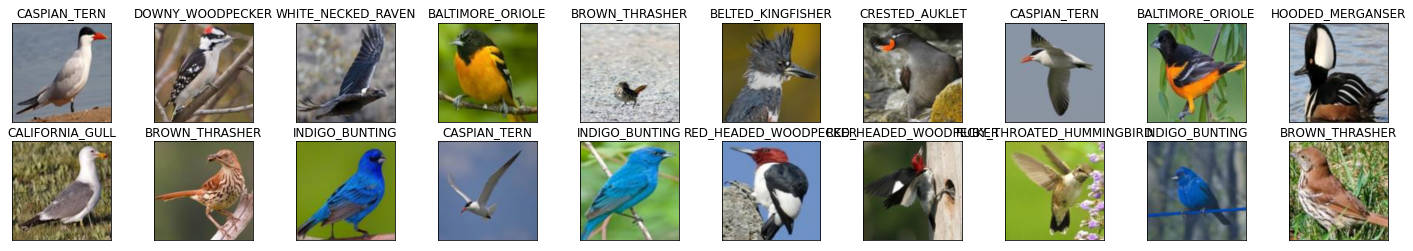

In [55]:
# 하나의 훈련 이미지 배치 얻기
dataiter = iter(train_loader)    # trainloader안의 실제값 확인
images, labels = dataiter.next() # 데이터를 하나씩 불러온다.
images = images.numpy()          # 보여주기 위해 이미지를 numpy로 변환

# 해당 라벨과 함께 배치의 이미지를 플로팅합니다.
fig = plt.figure(figsize=(25, 4)) # 최초 창의 크기를 25 x 4로 설정

for idx in np.arange(20): # 20개의 이미지를 보여줍니다.
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])  # figure 내에서 축을 가지는 하나의 좌표평면을 나타냅니다.
    imshow(images[idx]) # 인덱스에 대항하는 이미지를 보여줍니다.
    ax.set_title(classes[labels[idx]]) # 타이틀에 이미지에 해당하는 인덱스가 보이도록 합니다.

## Step 3: Neural Network 생성
- Pretrained model을 허용하지 않습니다. (직접 모델을 설계해 주세요)


In [56]:
train_on_gpu = torch.cuda.is_available()                 # CUDA를 사용할 수 있는지 확인

if not train_on_gpu:                                     # CUDA를 사용할 수 없다면
    device = 'cpu'                                       # device에 cpu 저장
    print('CUDA is not available.  Training on CPU ...') # CUDA 사용불가하여 CPU로 Training 한다는 정보를 출력한다.
else:                                                    # CUDA를 사용할 수 있다면
    device = 'cuda'                                      # device에 cuda 저장
    print('CUDA is available!  Training on GPU ...')     # CUDA 사용가능하여 CUDA로 Training 한다는 정보를 출력한다.

CUDA is available!  Training on GPU ...


---

 ## Step 4: Cost (Loss) Function 과 Optimizer 선택
 
 [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) 및 [optimizer](http://pytorch.org/docs/stable/optim.html)를 선택하여 코드를 완성하세요.
 
 위 링크에서 다양한 Loss Function과 Optimize Function을 확인 할 수 있습니다
 

In [58]:

class ConvNet(nn.Module):  # nn.Module 구현
    def __init__(self):    # 기본이 되는 층을 구현
        super().__init__() # 부모 생성자 호출 
        self.conv1 = nn.Conv2d(3,32,3, padding = 1)   # 32x32x3이기 때문에 input 채널을 3으로 맞추고 32개의 필터를 사용, 3x3 필터를 사용, padding을 1로 설정
        self.conv2 = nn.Conv2d(32,64,3,padding = 1)   # conv1에서 32개의 채널을 사용했기 때문에 input 채널을 32으로 설정, 64개의 필터를 사용, 3x3 필터를 사용, padding을 1로 설정 
        self.conv3 = nn.Conv2d(64,128,3,padding = 1)  # conv2에서 64개의 채널을 사용했기 때문에 input 채널을 64으로 설정, 128개의 필터를 사용, 3x3 필터를 사용, padding을 1로 설정 
        self.conv4 = nn.Conv2d(128,256,3,padding = 1) # conv3에서 128개의 채널을 사용했기 때문에 input 채널을 128으로 설정, 256개의 필터를 사용, 3x3 필터를 사용, padding을 1로 설정 
        self.conv5 = nn.Conv2d(256,512,3,padding = 1) # conv4에서 256개의 채널을 사용했기 때문에 input 채널을 256으로 설정, 512개의 필터를 사용, 3x3 필터를 사용, padding을 1로 설정 
        
        self.btn1 = nn.BatchNorm2d(32)  # conv1 에 대해 입력 32인 배치 정규화를 적용
        self.btn2 = nn.BatchNorm2d(64)  # conv2 에 대해 입력 64인 배치 정규화를 적용
        self.btn3 = nn.BatchNorm2d(128) # conv3 에 대해 입력 128인 배치 정규화를 적용
        self.btn4 = nn.BatchNorm2d(256) # conv4 에 대해 입력 256인 배치 정규화를 적용
        self.btn5 = nn.BatchNorm2d(512) # conv5 에 대해 입력 512인 배치 정규화를 적용
    
        self.pool = nn.MaxPool2d(2,2)     # maxpool의 크기를 2x2로 설정
        
        self.fc1 = nn.Linear(25088,12544) # 25088의 input을 12544개의 출력으로 바꿔준다
        self.fc2 = nn.Linear(12544,6272)  # 12544의 input을 6272개의 출력으로 바꿔준다
        self.fc3 = nn.Linear(6272,500)    # 6272의 input을 500개의 출력으로 바꿔준다
        self.fc4 = nn.Linear(500,15)      # 500의 input을 15개의 출력으로 바꿔준다
        
        self.fc1_btn = nn.BatchNorm1d(12544) # fc1에 대해 입력 12544인 배치 정규화를 적용
        self.fc2_btn = nn.BatchNorm1d(6272)  # fc2에 대해 입력 6272인 배치 정규화를 적용
        self.fc3_btn = nn.BatchNorm1d(500)   # fc3에 대해 입력 500인 배치 정규화를 적용
       
        self.dropout = nn.Dropout(0.5) # 오버피팅 방지를 위한 dropout 값 0.5 로 설정
        self.relu = nn.ReLU(True)      # 활성화 함수 ReLU 사용
    
    def forward(self, x): # init에서 만든 층을 불러와서 network 구성 (연산부분을 담당)
        x = self.pool(self.relu(self.btn1(self.conv1(x)))) # conv1에 대해 배치정규화를 진행한 후 relu를 적용하고 maxpool을 적용하여 크기를 변경
        x = self.pool(self.relu(self.btn2(self.conv2(x)))) # conv2에 대해 배치정규화를 진행한 후 relu를 적용하고 maxpool을 적용하여 크기를 변경
        x = self.pool(self.relu(self.btn3(self.conv3(x)))) # conv3에 대해 배치정규화를 진행한 후 relu를 적용하고 maxpool을 적용하여 크기를 변경
        x = self.pool(self.relu(self.btn4(self.conv4(x)))) # conv4에 대해 배치정규화를 진행한 후 relu를 적용하고 maxpool을 적용하여 크기를 변경
        x = self.pool(self.relu(self.btn5(self.conv5(x)))) # conv5에 대해 배치정규화를 진행한 후 relu를 적용하고 maxpool을 적용하여 크기를 변경
        
        x = x.view(x.size(0), -1)                # x의 모양을 플랫하게 변경
        x = self.dropout(x)                      # 오버피팅을 막기위해 x에 대한 dropout 적용
        x = self.relu(self.fc1_btn(self.fc1(x))) # fc1을 추가하고 배치정규화를 진행한 후 relu를 적용하여 크기를 변경
        x = self.dropout(x)                      # 오버피팅을 막기위해 x에 대한 dropout 적용
        x = self.relu(self.fc2_btn(self.fc2(x))) # fc2을 추가하고 배치정규화를 진행한 후 relu를 적용하여 크기를 변경
        x = self.dropout(x)                      # 오버피팅을 막기위해 x에 대한 dropout 적용
        x = self.relu(self.fc3_btn(self.fc3(x))) # fc3을 추가하고 배치정규화를 진행한 후 relu를 적용하여 크기를 변경
        x = self.dropout(x)                      # 오버피팅을 막기위해 x에 대한 dropout 적용
        x = self.relu(self.fc4(x))               # 출력층 fc4를 추가하고 relu를 적용
        return F.log_softmax(x,dim=1)            # log_softmax를 사용하여 output에 적용하여 결과 리


model = ConvNet()   # CNN instance 생성하여 모델 확인
model.to(device)    # CUDA를 사용할 수있는 경우 텐서를 GPU로 이동

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (btn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (btn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (btn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (btn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=12544, bias=True

In [59]:
 # loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()
# optimizer 정의(Adam)
optimizer = optim.Adam(model.parameters() , lr = 0.001)

---

## Step 5: 구성한 모델에 대한 Train and Validate 진행

* 코드 전체를 주석으로 설명하세요
* Epoch 별로 Loss나 Accuracy를 출력하여 학습 진행 과정을 확인 할 수 있도록 합니다
* 출력 예시는 주어지나 정해진 형식은 없습니다
* 최적의 모델 저장

예제:
```
Started Training...
Epoch: 1 	Training Loss: 3.317162 	Validation Loss: 4.162958
Epoch: 2 	Training Loss: 2.420140 	Validation Loss: 4.182362
...
...
Finished training
```

In [60]:
n_epochs = 200          # 모델 훈련을위한 Epoch 수
valid_loss_min = np.Inf # 검증 손실의 변화 추적

# 훈련 및 검증 손실 추적
train_loss = torch.zeros(n_epochs) # epoch 크기만큼 0으로 채워진 torch 생성
valid_loss = torch.zeros(n_epochs) # epoch 크기만큼 0으로 채워진 torch 생성

train_acc = torch.zeros(n_epochs)  # epoch 크기만큼 0으로 채워진 torch 생성
valid_acc = torch.zeros(n_epochs)  # epoch 크기만큼 0으로 채워진 torch 생성

#step size마다 gamma 비율로 lr을 감소시킨다. (step_size 마다 gamma를 곱한다.)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 

for e in range(0, n_epochs):       # epoch 크기만큼 반복문 실행
    ###################
    # train the model #
    ###################
    model.train()                                             # model.train() 을 호출하여 학습 모드로 전환
    for data, labels in train_loader:                         # data와 label 변수에 train_loader에 있는 값들을 하나씩 대입
        # CUDA를 사용할 수있는 경우 텐서를 GPU로 이동
        data, labels = data.to(device), labels.to(device)     # data와 label을 gpu를 사용해서 계산
        optimizer.zero_grad()                                 # 모든 최적화 된 변수의 기울기를 지 웁니다.
        logits = model(data)                                  # 모델에 입력을 전달하여 예측 출력을 계산합니다.
        loss = criterion(logits, labels)                      # 배치 손실을 계산합니다.
        loss.backward()                                       # 역방향 : 모델 매개 변수에 대한 손실의 기울기 계산
        optimizer.step()                                      # 단일 최적화 단계 수행 (매개 변수 업데이트)
        train_loss[e] += loss.item()                          # 훈련 손실 업데이트
        
        ps = F.softmax(logits, dim=1)                         # 데이터들을 Softmax 함수를 이용해서 확률로 바꿔준다
        top_p, top_class = ps.topk(1, dim=1)                  # topk는 k번째로 큰 숫자를 찾아내는 것이다. dim=1 는 dimension을 의미한다
        equals = top_class == labels.reshape(top_class.shape) # labels를 top_class와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()  # equals를 float으로 바꾸고 평균 정확도를 계산합니다.
    
    train_loss[e] /= len(train_loader)                       # train loss의 평균을 계산
    train_acc[e] /= len(train_loader)                        # train acc의 평균을 계산
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad():                          # 해당 블록을 history 트래킹 하지 않겠다는 의미로 사용
        model.eval()                               # model.eval() 을 호출하여 추론 결과가 일관성 없게 출력하도록 드롭아웃 및 배치 정규화를 평가 모드로 설정
        for data, labels in valid_loader:          # data와 label 변수에 valid_loader에 있는 값들을 하나씩 대입
            # CUDA를 사용할 수있는 경우 텐서를 GPU로 이동
            data, labels = data.to(device), labels.to(device) # data와 label을 gpu를 사용해서 계산
            logits = model(data)                              # 만들어둔 model에 data를 inmput으로 하여 output에 값을 저장
            loss = criterion(logits, labels)                  # 배치 손실 계산합니다.
            valid_loss[e] += loss.item()                      # 평균 유효성 검사 손실을 업데이트합니다.

            ps = F.softmax(logits, dim=1)                         # 데이터들을 Softmax 함수를 이용해서 확률로 바꿔준다
            top_p, top_class = ps.topk(1, dim=1)                  # topk는 k번째로 큰 숫자를 찾아내는 것이다. dim=1 는 dimension을 의미한다
            equals = top_class == labels.reshape(top_class.shape) # labels를 top_class와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu() # equals를 float으로 바꾸고 평균 정확도를 계산합니다.
    
    
    valid_loss[e] /= len(valid_loader) # valid의 손실의 평 계산
    valid_acc[e] /= len(valid_loader)  # valid의 정확도의 평균 계산
       
    scheduler.step() # 학습률 스케쥴러 실행
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e, train_loss[e], valid_loss[e]))       # epoch 크기와 그에 따른 train과 valid의 loss 값 출력
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(e, train_acc[e], valid_acc[e])) # epoch 크기와 그에 따른 train과 valid의 정확도 출력
    
    if valid_loss[e] <= valid_loss_min:  #검증 손실이 감소하면 모델을 저장합니다
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss[e])) # 저장된 valid_loss_min 과 valid_loss 를 출력합니다.
        torch.save(model.state_dict(), 'model.pt') # model.pt 로 모델을 저장합니다.
        valid_loss_min = valid_loss[e]    # 가장 낮은 손실값을 갖는 값을 valid_loss_min에 저장합니다.
        
print('Finished training') # 훈련 종료를 나타내는 문장을 출력합니다.

Epoch: 0 	Training Loss: 2.179821 	Validation Loss: 1.948848
Epoch: 0 	Training accuracy: 0.348992 	Validation accuracy: 0.411024
Validation loss decreased (inf --> 1.948848).  Saving model ...
Epoch: 1 	Training Loss: 1.535606 	Validation Loss: 1.379378
Epoch: 1 	Training accuracy: 0.544052 	Validation accuracy: 0.609028
Validation loss decreased (1.948848 --> 1.379378).  Saving model ...
Epoch: 2 	Training Loss: 1.248560 	Validation Loss: 1.094503
Epoch: 2 	Training accuracy: 0.633596 	Validation accuracy: 0.702474
Validation loss decreased (1.379378 --> 1.094503).  Saving model ...
Epoch: 3 	Training Loss: 1.017546 	Validation Loss: 1.057282
Epoch: 3 	Training accuracy: 0.695345 	Validation accuracy: 0.690451
Validation loss decreased (1.094503 --> 1.057282).  Saving model ...
Epoch: 4 	Training Loss: 0.848337 	Validation Loss: 1.045366
Epoch: 4 	Training accuracy: 0.738609 	Validation accuracy: 0.706163
Validation loss decreased (1.057282 --> 1.045366).  Saving model ...
Epoch: 5 	

## Step 6: CNN model training/validation 분석
   * tranining loss와 validation loss 그래프를 통해서 분석


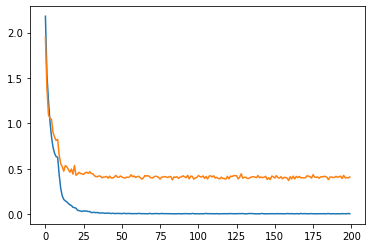

In [62]:
plt.plot(train_loss)            # train_loss 그래프를 그립니다
plt.plot(valid_loss)            # valid_loss 그래프를 그립니다

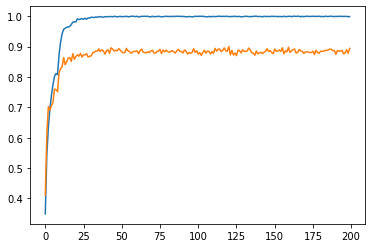

In [63]:
plt.plot(train_acc)            # train_acc 그래프를 그립니다
plt.plot(valid_acc)            # valid_acc 그래프를 그립니다

* 최적의 모델 로드

In [64]:
model.load_state_dict(torch.load('model.pt')) # 최적의 모델을 로드합니다

<All keys matched successfully>

---

## Step 7: Predict with Test Data 


### 예시 코드를 제공해 드립니다. 필요한 부분을 채워 사용하시거나 직접 코드를 작성 하셔도 됩니다

In [65]:
class test_dataset(Dataset): #test_dataset 클래스 정의 
    def __init__(self,imgpath,transform=None):
        self.imgpath = imgpath      # 이미지 경로를 설정할 변수를 설정합니다.
        self.transform = transform  # 전처리를 할 transform 변수를 설정합니다.
        
    def __len__(self):
        return len(self.imgpath) # imgpath 길이 값을 반환합니다.
    
    def __getitem__(self,idx): 
        x = self.transform(Image.open(self.imgpath[idx]).convert('RGB')) # 전처리를 수행하여 이미지의 값을 x에 저장합니다.
        return x # x값 반환하기

In [66]:
test_transform = transforms.Compose([                                                    # test_data에서 사용할 test transform을 구성합니다.
                                transforms.Resize((224,224)),                            # 이미지 사이즈를 224x224로 바꿉니다.
                                transforms.ToTensor(),                                   # 이미지를 텐서로 변형합니다.
                                transforms.Normalize((0.5 , 0.5, 0.5),(0.5 , 0.5, 0.5))  # 값을 MEANS : (0.5, 0.5, 0.5), DEVIATIOMS : (0.5, 0.5, 0.5) 값으로 정규화 시킵니다. 
                               ])

### test dataset과 dataloader 생성


In [67]:
test_set = sorted(glob.glob('../input/detectthebird/imgs/test/*')) # 파일명 순으로 정렬합니다.
test_data = test_dataset(test_set,test_transform)        # test_dataset을 통하여 데이터셋을 불러옵니다.
# DataLoader를 사용하여 test_dataset을 받아서 image와 여러개의 batch 로 정리하여 return 합니다
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

### Predict 수행

In [68]:
pred=[] # 빈 리스트 pred 생성합니다.
pred = torch.zeros(len(test_set)) # test_set의 크기만큼 0으로 채워진 torch 생성하여 pred에 저장합니다.

In [69]:
with torch.no_grad():              # 해당 블록을 history 트래킹 하지 않겠다는 의미로 사용
        cnt=0                      # cnt 값 0으로 초기화
        for data in test_loader:   # data 변수에 test_loader에 있는 값들을 하나씩 대입
            data = data.to(device) # CUDA를 사용할 수있는 경우 텐서를 GPU로 이동
            logits = model(data)   # 입력을 모델에 전달하여 예측 출력을 계산합니다
        
            ps = F.softmax(logits, dim=1)                         # 데이터들을 Softmax 함수를 이용해서 확률로 바꿔준다
            top_p, top_class = ps.topk(1, dim=1)                  # topk는 k번째로 큰 숫자를 찾아내는 것이다. dim=1 는 dimension을 의미한다
            
            for idx in np.arange(len(top_class)):                 # top_class의 크기의 평균만큼 반복
                pred[cnt] = top_class[idx]                        # pred[cnt] 에 top_class의 idx를 저장
                cnt+=1                                            # cnt 수 증가 

In [70]:
pred = pred.reshape(-1).to(dtype=torch.long, device=device) # pred의 배열을 reshape 하여 정리해줍니다.
pred  # pred에 저장되어 있는 내용을 출력합니다.

tensor([ 9,  8,  9, 13, 13,  6,  9,  3,  4,  6, 13,  7,  1,  8, 13, 14,  6,  8,
         2,  1,  7,  9,  4, 11,  0,  7,  1,  6,  4,  9,  7,  3,  9,  4,  5,  4,
        13, 11,  1,  7,  0,  3, 13,  9,  4,  7,  7,  5, 11,  2,  4, 10, 12,  2,
         4,  4,  7,  3, 12,  9,  6,  1, 13, 13, 14,  4, 11,  7, 12,  3,  3, 12,
         9, 13,  7,  1,  7,  5,  4,  4,  4,  3, 13,  2,  2,  2, 10,  3, 14,  8,
        13, 11, 13,  5,  3,  3, 11,  0, 11,  1,  9,  0, 13,  8, 10,  0,  8, 12,
         4, 12,  4, 13, 11, 11,  7, 12,  5,  6,  8,  4,  9,  7,  1,  0, 14,  9,
        13,  6,  4,  4, 11, 10, 11, 14,  7,  3,  6,  3,  1,  7,  2,  7,  8,  3,
        12,  6, 13,  2,  4,  3, 13,  8,  6,  7,  1, 11, 13,  2,  0,  7,  8,  2,
         7,  1, 10,  0,  1,  4,  2,  6,  4,  7,  5, 10,  3,  0,  5,  2,  4,  1,
         3,  6,  3,  6,  5,  4,  5, 11, 14, 11, 12,  3,  9,  4, 11, 10,  8, 14,
        13,  3,  8,  3, 11,  6, 10, 11,  9,  4, 12,  6,  0,  8, 14,  2, 13,  2,
         4,  5,  7,  1, 12,  7,  7, 12, 

In [72]:
classes = [i.split('/')[-1] for i in sorted(glob.glob('../input/detectthebird/imgs/train/*'))] # 이미지 클래스를 지정합니다.

In [73]:
classes # classes에 저장되어 있는 내용을 출력하여 확인합니다.

['AMERICAN_PIPIT',
 'BALTIMORE_ORIOLE',
 'BELTED_KINGFISHER',
 'BROWN_THRASHER',
 'CALIFORNIA_GULL',
 'CASPIAN_TERN',
 'CRESTED_AUKLET',
 'DOWNY_WOODPECKER',
 'GRAY_CATBIRD',
 'HOODED_MERGANSER',
 'INDIGO_BUNTING',
 'PURPLE_FINCH',
 'RED_HEADED_WOODPECKER',
 'RUBY_THROATED_HUMMINGBIRD',
 'WHITE_NECKED_RAVEN']

예측 결과 인덱스를 저장한 pred 값을 사용해 클래스를 매칭하기 위한 class_name을 담아 놓은 리스트입니다.

주의할 점은 Train과정에서 사용된 class label 값과 같은 순서로 저장이 되어 있어야 한다는 점입니다


In [74]:
id=[]                          # test set을 각각 저장할 id 생성합니다.
category =[]                   #예측결과에 따른 label 값을 저장할 category 생성합니다.
for i in range(len(test_set)): #test_set의 크기만큼 반복합니다.
    id.append(test_set[i].split('/')[-1]) # id에 test_set의 i번째 원소를 추가합니다.
    category.append(classes[pred[i]])     # category에 i번째에 해당하는 예측 label을 추가합니다.
pd.DataFrame({'Id':id,'Category':category}).to_csv('./submission.csv',index=False) #데이터 프레임으로 재구성 후에 csv파일로 변환하여 저장합니다.

---